# Analysing accuracy of robust and non-robust models
## Cross Comparison

In [14]:
class CrossAnalysisModule:
    """ Module for easy analysis of details.log json file and rgb images.

        Attributes
        ----------

        file_locations : {str : str}
            {df_name : file_location}

        dfs : {str : df}
            {df_name : dataframe from file_location}

        varyingVariables : [str]
            Variables in the json files that change cross images

        combinedDf : Dataframe
            Merged Dataframe (columns in ['is_correct', 'loss', 'prediction', 'id'] have been renamed to columnName_dfName)

        ----------
    
    """

    def __init__(self):
        # Attributes visible to user (settings of the module)
        self.file_locations = {}
        self.dfs = {}
        self.varyingVariables = []
        self.columns = []
        self.combinedDf = None
        self.imageDf = None

        # Image display attributes (prevent long lists of parameters)
        self._displayed_attributes = None
        self._num_display_columns = None
        self._displayed_predictions = None

    def addJsonFile(self, file_location, file_name, df_name):
        """ Adds a dataframe to the dictionary of dataframes from a json file.
            Assume that all json files were generated with the same config yaml file and have the same columns.

            Parameters:
                file_location (str): Location of folder containing details.log json file and the folder containing all rendered images
                    
                file_name (str): Name of details.log file (if it has not be renamed this would be details.log)
                df_name (str): Name of dataframe (Usually ML model name)

        """
        self.file_locations[df_name] = file_location
        self.dfs[df_name] = self._loadDetailsJson(file_location, file_name)
        if (len(self.varyingVariables)==0):
            self.varyingVariables = self._outputVaryingVariables(df_name)
            self.columns = self.dfs[df_name].columns
        else: #check that they all share the same varying variable as the first (Ensures that dataframes that be joined)
            assert self.varyingVariables == self._outputVaryingVariables(df_name)
            assert self.columns.tolist() == self.dfs[df_name].columns.tolist()
        print(df_name, "has been added to the list of dataframes.")

    def removeJsonFile(self, df_name):
        """ 
        Removes a dataframe from the dictionary of dataframes 
        
        Parameters:
                df_name (str): Name of dataframe you are removing
        
        """
        self.file_locations.pop(df_name)
        self.dfs.pop(df_name)
        if (len(self.dfs)<=0):
            self.varyingVariables = []
            self.columns = []
        if (self.imageDf == df_name):
            self.imageDf = None
        self.combinedDf = None
        print(df_name, "has been removed.")

    def getDfNames(self):
        """ Get list of df names """
        return list(self.dfs.keys())

    def _loadDetailsJson(self, file_location, file_name):
        """ Load json details.log 
        
            Parameters:
                file_location (str): Folder holding the details.log file (Assumes class_map.json also exists)
                file_name (str): Name of details.log file
        
        """
        import pandas as pd 
        import numpy as np
        import json
        import os
        class_map = json.load(open(os.path.join(file_location, 'class_maps.json')))
        df = pd.DataFrame.from_records(list(map(json.loads, open(os.path.join(file_location, file_name)).readlines())))
        df = df.drop('render_args', axis=1).join(pd.DataFrame(df.render_args.values.tolist()))
        df['prediction'] = df['prediction'].apply(lambda x: class_map[x[0]])
        df['is_correct'] = (df['is_correct'] == 'True') 
        df['loss'] = pd.to_numeric(df['loss'])
        return df
    
    def _outputVaryingVariables(self, df_name):
        """ Get list of dependent variables 
        
            Parameters:
                df_name (str): Name of dataframe you are getting the varying variables from 
        
        """
        varying_variables = []
        #ignore columns 0-3 ('is_correct', 'loss', 'prediction', 'id')
        for colname in self.dfs[df_name].columns[4:]:
            if (self.dfs[df_name][colname].dtype == "object"): # if it is not numeric
                if (self.dfs[df_name][colname].nunique() > 1):
                    varying_variables.append(colname)
            else: # if it is numeric
                if (self.dfs[df_name][colname].var() > 0.0001): 
                    varying_variables.append(colname)
        return varying_variables

    def overallAccuracy(self):
        """ Accuracy across all variables """
        import pandas as pd
        accuracy_dict = {}

        columns = []
        accuracies = []
        index = []
        for key, value in self.dfs.items():
            acc_per_model = value.groupby("model").mean()['is_correct']
            accuracy_dict[key] = acc_per_model.tolist()
            if (len(index)==0):
                index = acc_per_model.index.tolist()
            assert index == acc_per_model.index.tolist()
        df = pd.DataFrame.from_dict(accuracy_dict)
        df.index = index
        return df
    
    def variableSettingAccuracies(self, variable_name, model_name):
        """ Accuracy on one variable for 1 3d model (eg. cup model), across different values 
            
            Parameters:
                variable_name (str): The independent variable (Variable that will be changing)
                model_name (str): Name of 3D model that you are viewing changing accuracies for
        
        """
        returned_df = None
        if (variable_name in self.varyingVariables):
            for key, value in self.dfs.items():
                temp = value[value['model']==model_name].groupby(variable_name).agg(
                        accuracy=('is_correct', 'mean'))
                temp.rename(columns={"accuracy":("acc_"+key)}, inplace=True)
                if (returned_df is None):
                    returned_df=temp
                else:
                    returned_df = returned_df.join(temp)
            returned_df.sort_index(inplace=True)
            return returned_df
        else:
            print("Variable name either does not exist in the dataframe or remains constant through the experiment")
            print("Valid Variable Entries: "+ str(self.varyingVariables))
            print("To get overall accuracy use .overallAccuracy()")

    def getCombinedDf(self):
        """ Method to get dataframes that are combined """
        import pandas as pd
        if (self.combinedDf is None): 
            combinedDf = None
            important_columns = ['is_correct', 'loss', 'prediction', 'id']
            joining_columns = important_columns.copy()
            joining_columns.extend(self.varyingVariables)
            other_columns = list(set(self.columns) - set(joining_columns))
            for key, value in self.dfs.items():
                if (combinedDf is None): #first df
                    impt = value[important_columns]
                    impt.columns = [(str(col)+"_"+key) for col in impt.columns]
                    combinedDf = pd.concat([impt, value[self.varyingVariables]], axis=1)
                else: #all other df
                    impt = value[important_columns]
                    impt.columns = [(str(col)+"_"+key) for col in impt.columns]
                    concat = pd.concat([impt, value[self.varyingVariables]], axis=1)
                    combinedDf=combinedDf.merge(concat, how='inner', on=self.varyingVariables)
            combinedDf = pd.concat([combinedDf, next(iter(self.dfs.values()))[other_columns]], axis=1)
            self.combinedDf = combinedDf.sort_index(axis=1)
            return self.combinedDf
        else:
            return self.combinedDf

    def _getImageDf(self):
        """ Method to get name of image dataframe """
        if (self.imageDf is None):
            print("Existing dfs:", self.getDfNames())
            imageDf = input("Name of dataframe with images: ")
            if (imageDf in self.getDfNames()):
                self.imageDf = imageDf
                return self.imageDf
            else:
                print("Entered dataframe is not in existing df list!")
                return
        else:
            return self.imageDf
        

    def _filterImageIds(self, filter_input):
        """
        Get list of ids of images that pass through the filters

        Filter_input should be in this format (inclusive of edges):

            filter_input = { 
                'HazeControl.haze_fac' : 0,
                'OrbitingCameraControl.theta': (0, 1.57),
                'RainControl.n_layers_of_rain': (0, 3),
                'SunControl.elevation': 0
            }
        
        For filter variables ['is_correct', 'loss', 'prediction', 'id'], add "_df_name" after the variable.
        Eg. "id_non_rob" if non_rob is the df_name      
        """
        #ensure that we are filtering by existent columns in the dataframe
        if (not (all(elem in self.getCombinedDf().columns for elem in filter_input))):
            print("Not all columns in filter_input are in the combined dataframe")
            return

        imageDf = self._getImageDf()
        filtered_df = self.getCombinedDf()
        for key, value in filter_input.items():
            if (type(value) is tuple or type(value) is list):
                filtered_df = filtered_df.loc[(filtered_df[key]<=value[1]) & (filtered_df[key]>=value[0])]
            else:
                filtered_df = filtered_df.loc[filtered_df[key]==value]
        return filtered_df[('id_'+imageDf)].tolist()

    def _getImageLabel(self, image_id):
        """ Get label of an image (Called by _showOneImage)"""
        imageDf = self._getImageDf()
        dictionaryToDisplay = self.dfs[imageDf][self.dfs[imageDf]['id']==image_id][self._displayed_attributes].to_dict('records')[0]
        label = ""
        for key, value in dictionaryToDisplay.items():
            if (isinstance(value, float)):
                value = round(value, 3)
            label += str(key)+": "+ str(value)+"\n"
        return label
    
    def _getImageCorrect(self, image_id, df_name):
        """ Find out if image was correctly predicted by the model. (Called by _showOneImage)"""
        import pandas as pd 
        imageDf = self._getImageDf()
        combinedDf = self.getCombinedDf()
        return combinedDf[combinedDf[("id_"+imageDf)]==image_id]['is_correct_'+df_name].bool()

    def _getImagePrediction(self, image_id, df_name):
        """ Find out if image was correctly predicted by the ML model. (Called by _showOneImage)"""
        import pandas as pd 
        imageDf = self._getImageDf()
        combinedDf = self.getCombinedDf()
        return combinedDf[combinedDf[("id_"+imageDf)]==image_id]['prediction_'+df_name].to_string(index=False)

    def _getFigureDims(self, image_ids):
        """ Method to calculate figure dimensions (Called by _showImages)
        
            Parameters:
                image_ids (list of str): List of image ids we are making the figure out of
        
        """
        from math import ceil
        # Get number of rows
        num_images = len(image_ids)
        rows = ceil(num_images/self._num_display_columns)

        #Calculate figure dimensions
        figure_width = 20
        size_of_each_image = figure_width/self._num_display_columns
        size_of_each_line_in_label = 0.5
        size_of_image_and_label = size_of_each_image + size_of_each_line_in_label*len(self._displayed_attributes)
        figure_height = rows * size_of_image_and_label
        return rows, self._num_display_columns, figure_width, figure_height

    def _showOneImage(self, image_location, image_id, ax):
        """ Method to show 1 image given an image_id (Called by _showImages) 
        
            Parameters:
                image_location (str): Location of folder holding the image
                image_id (str): id of the image
                ax (matplotlib.pyplot.axes): The axes of the image

        """
        import os
        import matplotlib.pyplot as plt
        from matplotlib.image import imread
        
        #get image filename
        image_filename = os.path.join(image_location, (image_id+"_rgb.png"))
        #Title of image (contains displayed_values)
        ax.set_title(self._getImageLabel(image_id))
        for i, key in enumerate(self._displayed_predictions):
            color = "green" if self._getImageCorrect(image_id, key) else "red"
            ax.text(9 , 17+i*20, str(self._getImagePrediction(image_id, key)),color=color,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 4})
        plt.imshow(imread(image_filename))

    def _showImages(self, image_ids):
        """ Method to show images from a list of image_ids (Called by showFilteredImages and viewAdversarialImages)"""

        import matplotlib.pyplot as plt
        import os

        imageDf = self._getImageDf()

        #ensure that columns in displayed_values can be found in the dataframe
        if (not (all(elem in self.columns for elem in self._displayed_attributes))):
            print("Not all attributes in displayed_attributes are in the dataframe")
            return
        elif (len(self._displayed_attributes)==0): #if no values entered for self._displayed_attributes
            self._displayed_attributes=self.varyingVariables

        #ensure that df_names in displayed_predictions can be found in the exisitng dataframes
        if (not (all(elem in self.getDfNames() for elem in self._displayed_predictions))):
            print("Not all df_names are in displayed_predictions are in the existing df list")
            return
        elif (len(self._displayed_predictions)==0): #if no values entered for self._displayed_predictions
            self._displayed_predictions=self.getDfNames()

        #ensure that all image_ids are in the dataframe
        if (not (all(elem in list(self.dfs[imageDf]['id']) for elem in image_ids))):
            print("Not all image ids in the image dataframe", ",", imageDf)
            return

        #if there are no images
        elif (len(image_ids)<=0):
            print("There are no images.")
            return

        #Get figure dimensions
        rows, columns, figure_width, figure_height = self._getFigureDims(image_ids)

        #Get image location
        image_location = os.path.join(self.file_locations[imageDf], 'images')

        #plot images
        plt.figure(figsize=(figure_width, figure_height))
        for i, image_id in enumerate(image_ids):
            ax = plt.subplot(rows, columns, i + 1)
            self._showOneImage(image_location, image_id, ax)
        plt.show()

    def showFilteredImages(self, filter_input, num_display_columns=4, displayed_attributes=[], displayed_predictions=[]):
        """ Show Filtered Images 

            Filter_input should be in this format (inclusive of edges):

            filter_input = { 
                'HazeControl.haze_fac' : 0,
                'OrbitingCameraControl.theta': (0, 1.57),
                'RainControl.n_layers_of_rain': (0, 3),
                'SunControl.elevation': 0
            }

            Parameters:
                    filter_input (dictionary): Settings to filter images
                    num_display_columns (int): Number of images in each row
                    displayed_attributes (list of str): Attributes of an image to be displayed
                    displayed_predictions (list of str): List of names of dfs (ML models) that you want to see the predictions of
        
        """
        image_ids = self._filterImageIds(filter_input)
        self._displayed_attributes = displayed_attributes
        self._num_display_columns = num_display_columns
        self._displayed_predictions = displayed_predictions
        self._showImages(image_ids)

    def getAdversarialImageIDs(self, df_name):
        """ Get adversarial image ids for each 3D model for each dataframe (ML model)
            Adversarial image: Image with the highest loss out of all images of this 3D model

            Parameters:
                    df_name (str): Given name of df (usually ML model's name)

        """
        max_loss_per_object = self.dfs[df_name].groupby("model").max()[('loss')].to_dict()
        return_dict = {}
        for model, loss in max_loss_per_object.items():
            filter_input = {
                ("loss_"+df_name): loss,
                "model": model
            }
            return_dict[model]=self._filterImageIds(filter_input)[0]
        return return_dict
    
    def viewAdversarialImages(self, df_name, displayed_predictions=[], num_display_columns=4, displayed_attributes=[]):
        """ Show adversarial image for each 3D model for each dataframe (ML model)
            Adversarial image: Image with the highest loss out of all images of this 3D model
        
            Parameters:
                    df_name (str): Given name of df (usually ML model's name)
                    displayed_predictions (list of str): List of names of dfs (ML models) that you want to see the predictions of
        
        """
        if (len(displayed_predictions)==0):
            displayed_predictions = [df_name]
        imageIds = list(self.getAdversarialImageIDs(df_name).values())
        # set display attributes
        self._displayed_attributes = displayed_attributes
        self._num_display_columns = num_display_columns
        self._displayed_predictions = displayed_predictions
        self._showImages(imageIds)

In [16]:
analysis = CrossAnalysisModule()
analysis.addJsonFile("../non_robust/results", "details_non_rob.log", "non_rob")
analysis.addJsonFile("../robust/results", "details_imagenet_l2_3_0.pt.log", "l2_3_0")
analysis.addJsonFile("../robust/results", "details_imagenet_linf_4.pt.log", "linf_4")
analysis.addJsonFile("../robust/results", "details_imagenet_linf_8.pt.log", "linf_8")

non_rob has been added to the list of dataframes.
l2_3_0 has been added to the list of dataframes.
linf_4 has been added to the list of dataframes.
linf_8 has been added to the list of dataframes.


In [17]:
analysis.varyingVariables

['model', 'OrbitingCameraControl.phi', 'OrbitingCameraControl.theta']

In [18]:
analysis.overallAccuracy().to_csv("csvs/overall_accuracy.csv")
analysis.overallAccuracy()

,non_rob,l2_3_0,linf_4,linf_8
011_banana.blend,0.78,0.25,0.31,0.49
017_orange.blend,0.15,0.39,0.00,0.29
025_mug.blend,0.18,0.03,0.25,0.34
035_power_drill.blend,0.91,0.51,0.54,0.47
cup.blend,0.57,0.01,0.01,0.03


In [19]:
analysis.variableSettingAccuracies("OrbitingCameraControl.phi", "025_mug.blend").to_csv("csvs/varying_phi_mug.csv")
analysis.variableSettingAccuracies("OrbitingCameraControl.phi", "025_mug.blend")

,acc_non_rob,acc_l2_3_0,acc_linf_4,acc_linf_8
OrbitingCameraControl.phi,,,,
0.000000,0.2,0.0,0.0,0.0
0.174444,0.0,0.0,0.2,0.0
0.348889,0.1,0.0,0.0,0.3
0.523333,0.1,0.0,0.1,0.5
0.697778,0.3,0.0,0.3,0.5
0.872222,0.1,0.0,0.3,0.5
1.046667,0.0,0.2,0.4,0.7
1.221111,0.2,0.0,0.4,0.4
1.395556,0.4,0.1,0.4,0.3


In [20]:
analysis.variableSettingAccuracies("OrbitingCameraControl.theta", "025_mug.blend").to_csv("csvs/varying_theta_mug.csv")
analysis.variableSettingAccuracies("OrbitingCameraControl.theta", "025_mug.blend")

,acc_non_rob,acc_l2_3_0,acc_linf_4,acc_linf_8
OrbitingCameraControl.theta,,,,
-3.140,0.0,0.0,0.0,0.0
-2.512,0.1,0.0,0.0,0.1
-1.884,0.3,0.0,0.7,0.7
-1.256,0.6,0.2,0.8,0.6
-0.628,0.2,0.0,0.0,0.3
0.000,0.0,0.0,0.0,0.0
0.628,0.1,0.0,0.0,0.3
1.256,0.3,0.1,0.6,0.8
1.884,0.2,0.0,0.4,0.5


In [21]:
# analysis.variableSettingAccuracies("OrbitingCameraControl.phi", "cup.blend").to_csv("csvs/varying_phi_cup.csv")
analysis.variableSettingAccuracies("OrbitingCameraControl.phi", "cup.blend")

,acc_non_rob,acc_l2_3_0,acc_linf_4,acc_linf_8
OrbitingCameraControl.phi,,,,
0.000000,0.0,0.0,0.0,0.0
0.174444,0.1,0.0,0.0,0.0
0.348889,0.6,0.0,0.0,0.0
0.523333,0.6,0.0,0.0,0.0
0.697778,0.4,0.0,0.0,0.0
0.872222,0.5,0.0,0.0,0.0
1.046667,1.0,0.0,0.0,0.2
1.221111,1.0,0.1,0.1,0.1
1.395556,0.9,0.0,0.0,0.0


In [22]:
analysis.variableSettingAccuracies("OrbitingCameraControl.theta", "cup.blend").to_csv("csvs/varying_theta_cup.csv")
analysis.variableSettingAccuracies("OrbitingCameraControl.theta", "cup.blend")

,acc_non_rob,acc_l2_3_0,acc_linf_4,acc_linf_8
OrbitingCameraControl.theta,,,,
-3.140,0.9,0.1,0.0,0.0
-2.512,0.5,0.0,0.0,0.0
-1.884,0.5,0.0,0.0,0.0
-1.256,0.8,0.0,0.0,0.0
-0.628,0.7,0.0,0.1,0.2
0.000,0.3,0.0,0.0,0.0
0.628,0.2,0.0,0.0,0.1
1.256,0.5,0.0,0.0,0.0
1.884,0.5,0.0,0.0,0.0


In [23]:
analysis.getCombinedDf().to_csv("csvs/merged_df.csv")
analysis.getCombinedDf().head()

,OrbitingCameraControl.object_x,OrbitingCameraControl.object_y,OrbitingCameraControl.object_z,OrbitingCameraControl.phi,OrbitingCameraControl.radius,OrbitingCameraControl.theta,SunControl.air,SunControl.altitude,SunControl.background_strength,SunControl.dust,...,loss_l2_3_0,loss_linf_4,loss_linf_8,loss_non_rob,model,output_type,prediction_l2_3_0,prediction_linf_4,prediction_linf_8,prediction_non_rob
0,-0.5,0,0.253,0.0,0.3,-3.140,3.0,1.0,0.1,1.0,...,5.292597,4.187427,5.067661,4.614109,025_mug.blend,classes,birdhouse,birdhouse,birdhouse,"plunger, plumber""s helper"
1,-0.5,0,0.253,0.0,0.3,-2.512,3.0,1.0,0.1,1.0,...,4.440272,2.569937,3.737248,2.117273,025_mug.blend,classes,"flatworm, platyhelminth",birdhouse,birdhouse,coffee mug
2,-0.5,0,0.253,0.0,0.3,-1.884,3.0,1.0,0.1,1.0,...,3.692435,2.266025,2.862688,2.324173,025_mug.blend,classes,"flatworm, platyhelminth",birdhouse,birdhouse,cup
3,-0.5,0,0.253,0.0,0.3,-1.256,3.0,1.0,0.1,1.0,...,3.880995,2.515762,3.444767,1.445013,025_mug.blend,classes,"flatworm, platyhelminth",birdhouse,birdhouse,coffee mug
4,-0.5,0,0.253,0.0,0.3,-0.628,3.0,1.0,0.1,1.0,...,4.277936,2.802733,3.910763,2.573457,025_mug.blend,classes,"flatworm, platyhelminth",birdhouse,birdhouse,red wine


Existing dfs: ['non_rob', 'l2_3_0', 'linf_4', 'linf_8']


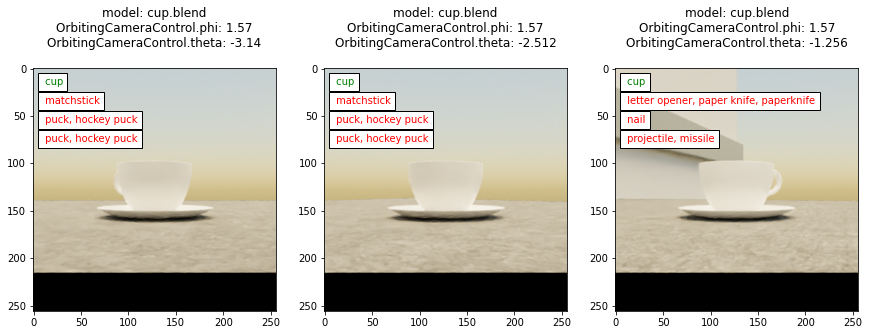

In [24]:
filter_input = { #inclusive of edges
        "OrbitingCameraControl.phi": 1.57,
        "OrbitingCameraControl.theta": (-3.14,0),
        "model":"cup.blend",
        "is_correct_non_rob": True
    }
analysis.showFilteredImages(filter_input)

In [25]:
analysis.getAdversarialImageIDs('non_rob')

{'011_banana.blend': '659a7476-0808-427c-87e5-4594b028cadf',
 '017_orange.blend': '4e5b6be6-e632-43fd-aaa9-27bf5ab6bc9e',
 '025_mug.blend': '54cf4d84-60c0-4834-aabe-6f5347b03565',
 '035_power_drill.blend': 'a705041f-e2fd-41ce-bea2-32a298bdefab',
 'cup.blend': '41dce053-0759-4839-b461-e126a86ccc4b'}

In [26]:
analysis.getAdversarialImageIDs('l2_3_0')

{'011_banana.blend': '879a27ba-f710-4d84-924a-76e8332e0e9a',
 '017_orange.blend': 'c75a06a6-22ce-4761-b4b1-30f410c23cbd',
 '025_mug.blend': 'c33ded10-d5ca-4e99-a89f-3523a1b5498f',
 '035_power_drill.blend': '42c6202a-0e12-40dd-a76d-f4aea1318f41',
 'cup.blend': '41dce053-0759-4839-b461-e126a86ccc4b'}

In [27]:
analysis.getAdversarialImageIDs('linf_4')

{'011_banana.blend': 'f555a5ac-3c57-410a-b509-131627f4e8a8',
 '017_orange.blend': 'c75a06a6-22ce-4761-b4b1-30f410c23cbd',
 '025_mug.blend': 'c33ded10-d5ca-4e99-a89f-3523a1b5498f',
 '035_power_drill.blend': '42c6202a-0e12-40dd-a76d-f4aea1318f41',
 'cup.blend': 'c8c0be92-a175-438d-901b-17d9a68ddbea'}

In [28]:
analysis.getAdversarialImageIDs('linf_8')

{'011_banana.blend': '8446a539-c070-4a33-88a9-51e809b6a449',
 '017_orange.blend': '41f6cef1-9a16-4836-b533-84d64b114f33',
 '025_mug.blend': '1d8e0d62-5796-4148-b481-154d13a50ac8',
 '035_power_drill.blend': '42c6202a-0e12-40dd-a76d-f4aea1318f41',
 'cup.blend': '2039c261-197c-41f9-9698-1f66a0a5e6e2'}

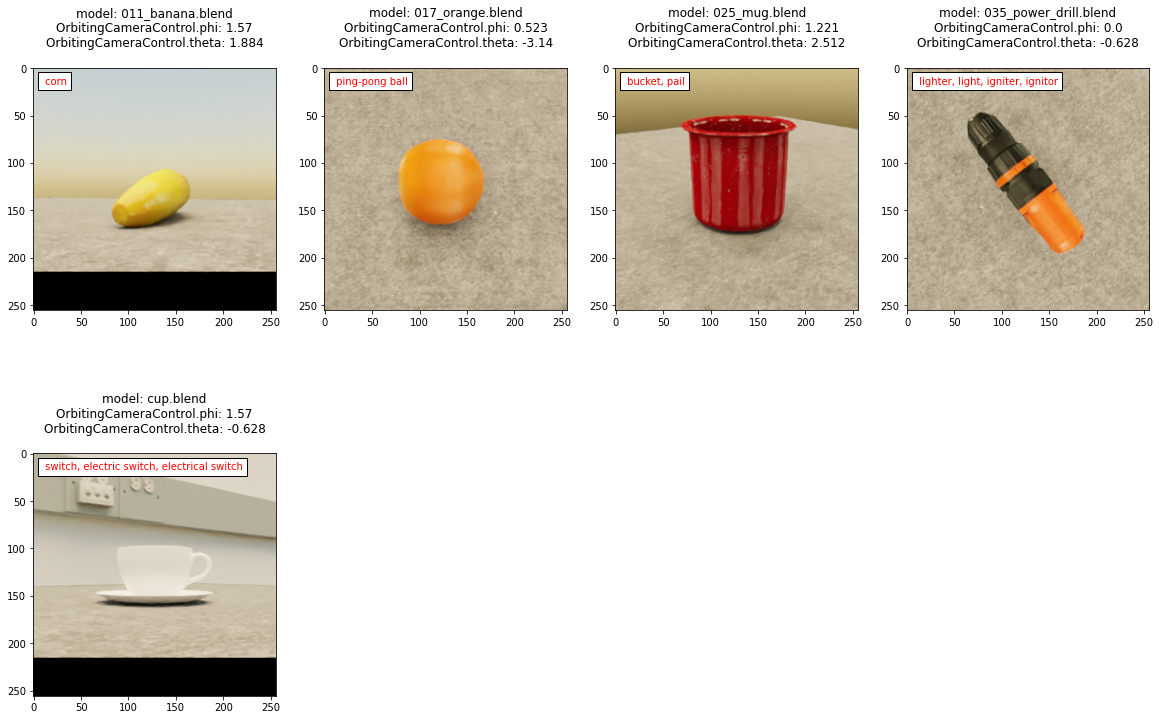

In [29]:
analysis.viewAdversarialImages('non_rob')

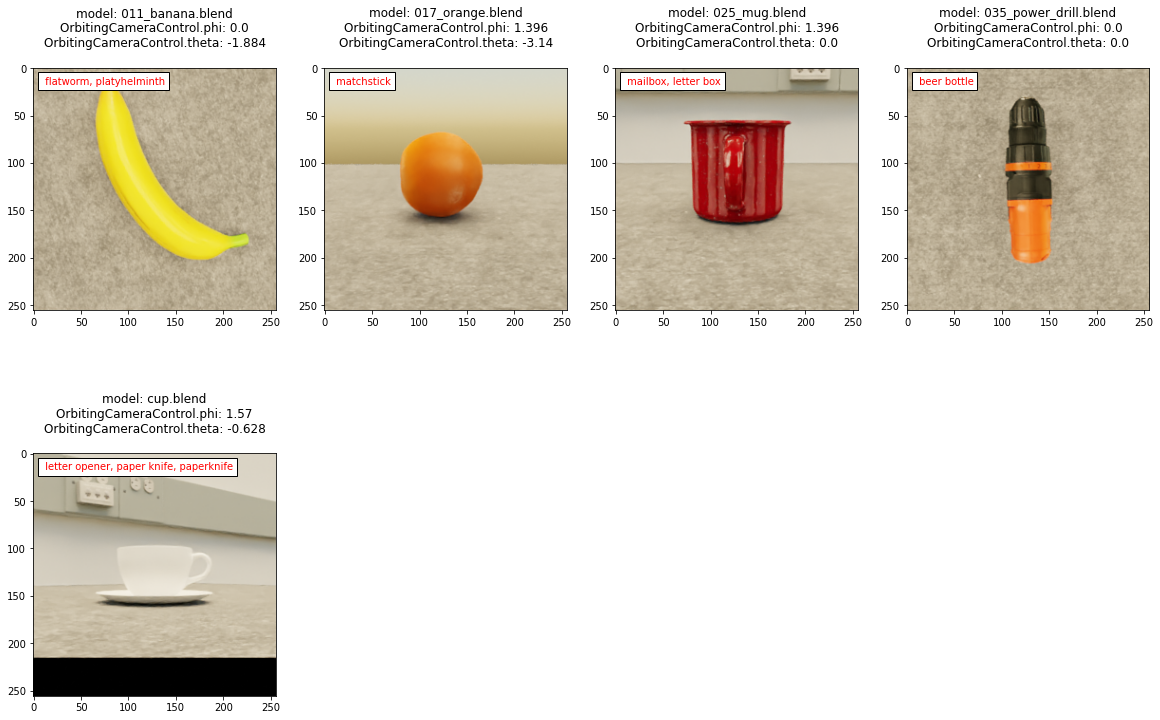

In [32]:
analysis.viewAdversarialImages('l2_3_0')

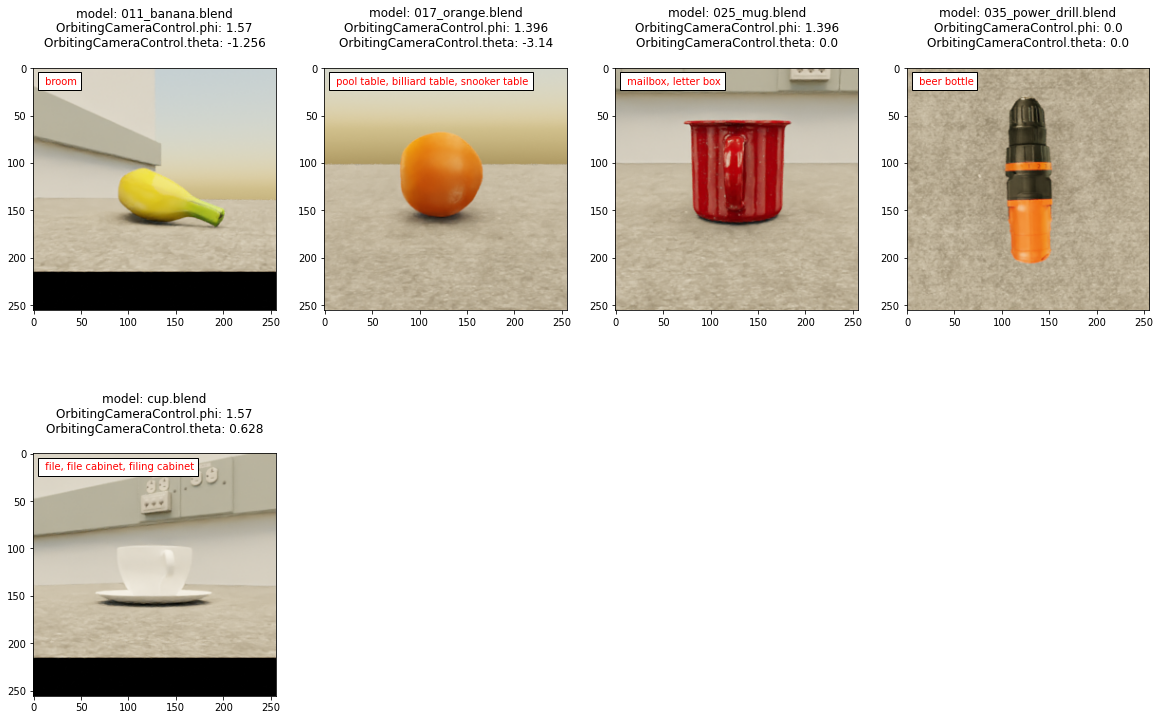

In [33]:
analysis.viewAdversarialImages('linf_4')

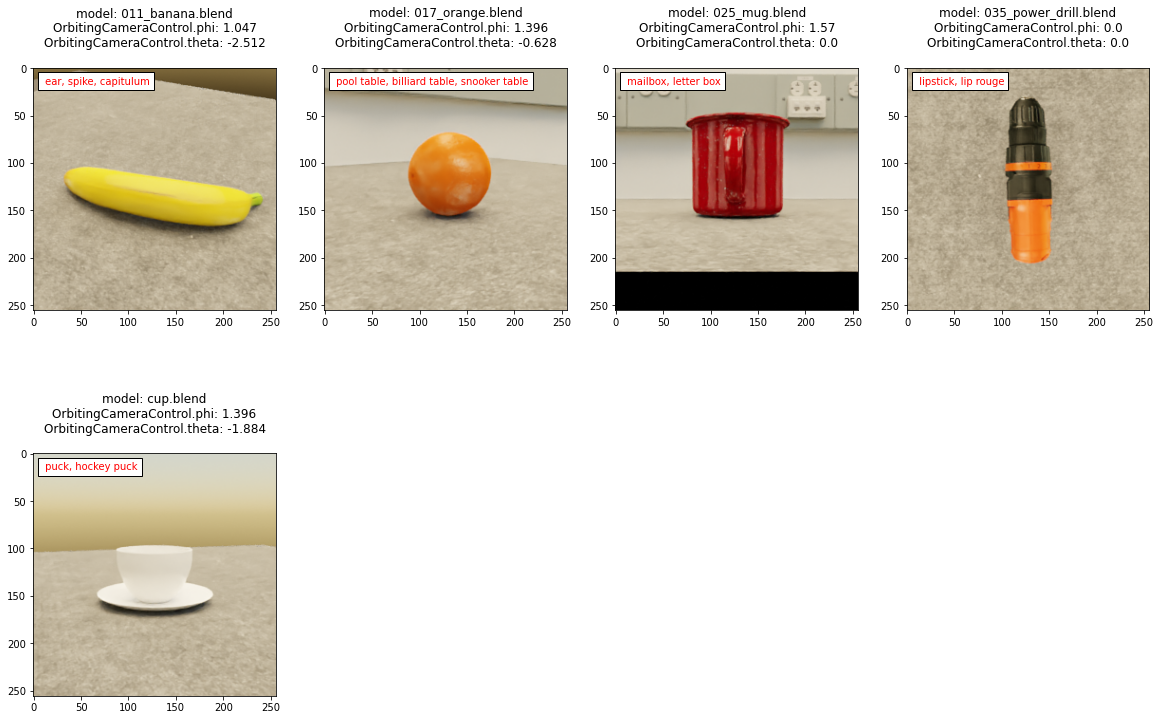

In [34]:
analysis.viewAdversarialImages('linf_8')